In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch.optim as optim
import copy
from PIL import Image
import math
from skimage.metrics import structural_similarity as ssim
import neptune
from tqdm import tqdm
import uuid

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# adding neptuneai integration for the run

#create a random runid for neptuneai run
run_id = str(uuid.uuid4())

# initialize a new neptuneai run
run = neptune.init_run(
    project="ImgResProject/SRCNN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMDFiMjI3Zi1kZjQxLTQ0MjktYjU2My1iM2ZmMWUxNjM4MGMifQ==",
    tags=["SRCNN"],
    name="SRCNN-4"
)

# add the runid to neptuneai id
run["id"] = run_id

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ImgResProject/SRCNN/e/FSRCNN-5


In [4]:
# for loading dataset
class SuperResolutionDataset(Dataset):
    def __init__(self, low_res_image_dir, high_res_image_dir, csv_file=None, image_data=None, transform=None):
        if image_data is not None:
            self.image_data = image_data
        elif csv_file is not None:
            self.image_data = pd.read_csv(csv_file)
        self.transform = transform
        self.fixed_size = (800, 1200)
        self.csv_file = csv_file
        self.high_res_image_dir = high_res_image_dir
        self.low_res_image_dir = low_res_image_dir

        if len(self.image_data) == 0:
            raise ValueError(f"No image files found in CSV file: {csv_file}")
        
        print(f"Found {len(self.image_data)} image pairs.")

    def __len__(self):
        return len(self.image_data)
    
    def train_val_test_split(self, r1, r2, r3):
        assert r1 + r2 + r3 == 1, "Ratios must sum to 1"
        
        train_data, temp_data = train_test_split(self.image_data, test_size=(1 - r1))
        val_data, test_data = train_test_split(temp_data, test_size=(r3 / (r2 + r3)))
        
        train_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=train_data.reset_index(drop=True),
                                               transform=self.transform)
        
        val_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=val_data.reset_index(drop=True),
                                               transform=self.transform)
        
        test_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=test_data.reset_index(drop=True),
                                               transform=self.transform)
        
        return train_dataset, val_dataset, test_dataset

    def __getitem__(self, index):
        # get image names in folders using index
        lr_image_path = self.image_data.iloc[index, 0]
        hr_image_path = self.image_data.iloc[index, 1]

        # add image path and convert it to RGB
        lr_img = Image.open(self.low_res_image_dir+lr_image_path).convert('RGB')
        hr_img = Image.open(self.high_res_image_dir+hr_image_path).convert('RGB')

        # resixe low res image to high res image size
        lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)

        #apply transform for both images
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)
        return lr_img, hr_img

In [21]:
# define resize and transform
transform = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.Resize((384, 384), interpolation=Image.BICUBIC),
    transforms.ToTensor()
])

img_set_path = "../Image Super Resolution - Unsplash/"

# load and apply transform to all images and map csv file mapping from low res to high res images
img_dataset = SuperResolutionDataset(csv_file=img_set_path+"image_data.csv",
                                     low_res_image_dir= img_set_path+"/low res/",
                                     high_res_image_dir= img_set_path+"/high res/",
                                     transform=transform)

Found 3762 image pairs.


/scratch/16368696/ipykernel_649006/3100128131.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((384, 384), interpolation=Image.BICUBIC),


In [22]:
# split the dataset to train test and validation in ratio 70:15:15
train_dataset, val_dataset, test_dataset = img_dataset.train_val_test_split(0.7, 0.15, 0.15)

Found 2633 image pairs.
Found 564 image pairs.
Found 565 image pairs.


In [7]:
# Function to show lowres and high res images side by side
def show_tensorpair(tensor_pair):
    # convert to numpy for display
    lr_img = tensor_pair[0].cpu().numpy()
    hr_img = tensor_pair[1].cpu().numpy()
    # transpose the image reording the dimension from tensor to matplotlib use
    lr_img = lr_img.transpose(1,2,0)
    hr_img = hr_img.transpose(1,2,0)

    # display images using subplot
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    axs[0].imshow(lr_img, cmap='gray')
    axs[0].set_title('Low-res Image')
    axs[0].axis('off')
    axs[1].imshow(hr_img, cmap='gray')
    axs[1].set_title('High-res Image')
    axs[1].axis('off')
    
    plt.show()

/scratch/16368696/ipykernel_649006/1594376166.py:55: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)


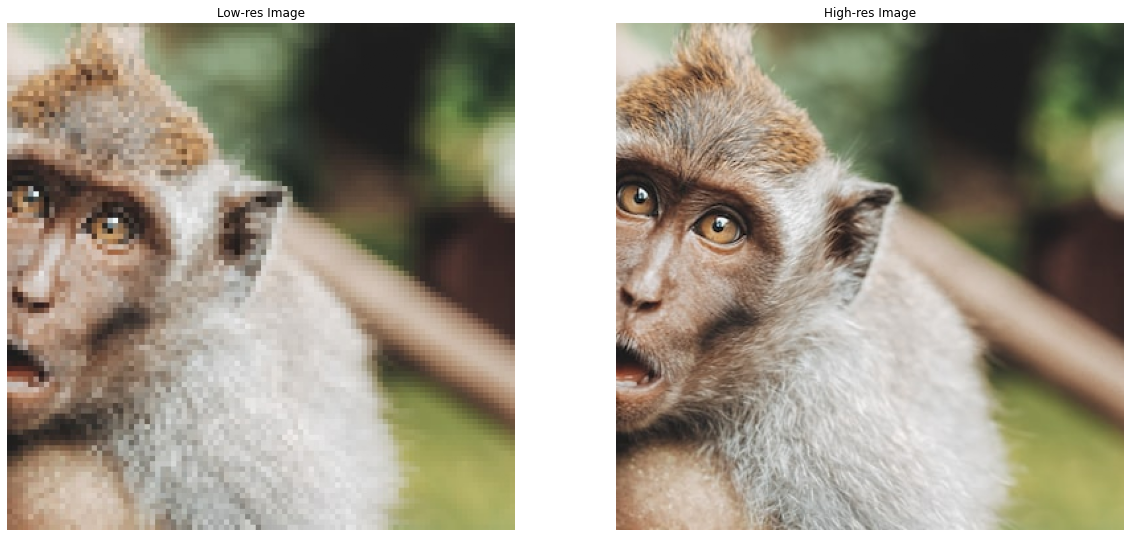

In [23]:
#display single sample image
show_tensorpair(train_dataset[5])
#train_dataset[0][2]

In [24]:
# creater dataloade for each dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [25]:
#defining Super Resolution Convolutional Neural Network

# SRCNN uses 3 convolution layers with relu as activation function
class SRCNN_paper(nn.Module):
    def __init__(self, num_channels=1):
        
        super(SRCNN_paper, self).__init__()

        # best setting kernel size mentioned in paper is filter1 = 9, filter2 = 5, filter3 = 5 
        # number of channels n1 = 64, n2 = 32 and n3 = number of channels of original image
        # formula for same image size after a[pplying kernel - padding should be (kernel-1)/2

        # checked with 11-7-7 version but as it was taking too much time, revert back to 9-5-5 version
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=2)
        # defininf relu acrtivation function
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # 2 non linear layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        # linear mapping layer
        x = self.conv3(x)
        return x

In [26]:
# function to calculate psnr - given by 10 * log10(R/sqrt(MSE))
def calculate_psnr(img1, img2):
    # calculate MSE loss first
    mse = nn.functional.mse_loss(img1, img2)

    # if both images are same : mse will be zero - handle it
    if mse == 0:
        return float('inf')
    # Determine the maximum pixel value
    if img1.dtype == torch.uint8:
        max_pixel = 255.0
    elif img1.dtype == torch.float32:
        max_pixel = 1.0

    #psnr calculation formula = 10 * log10(R/sqrt(MSE)) where R is maximum pizel since we are dealing in float = it is 1.0
    return 10 * math.log10(1.0 / mse.item())


In [27]:
def calculate_ssim(img1, img2):

    # initialize required value to store ssim avlues for each image
    ssim_values = []
    batch_size= img1.shape[0]
    

    # iterate over each image in the batch
    for i in range(batch_size):

        # average SSIM values across channels
        opimg = np.transpose(img1[i].cpu().numpy(), (1, 2, 0))
        ogimg = np.transpose(img2[i].cpu().numpy(), (1, 2, 0))

        ssim_val = ssim(opimg, ogimg, channel_axis=-1, data_range=ogimg.max() - ogimg.min())
        # take mean of all channels as ssim value for the image
        ssim_values.append(np.mean(ssim_val))

    # if there are any nan values then make it 0.0
    ssim_values = [0.0 if np.isnan(x) else x for x in ssim_values]

    if np.isnan(np.mean(ssim_values)):
        print(ssim_values)

    # return avrage of all images in the batch and return it as ssim value of all images in the batch
    return np.mean(ssim_values)

In [28]:
import gc
def test_model(model, test_loader, img_cnt=5):
        
    #eval mode for validation
    model.eval()
    # calculatinf peak signal to noise ratio
    psnr = 0.0
    ssim = 0.0
    count=0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_img, hr_img = lr_imgs.to(device), hr_imgs.to(device)

            # apply tained model on lores image
            outputs = model(lr_img)
            # calculate psnr and add
            psnr += calculate_psnr(outputs, hr_img)
            ssim += calculate_ssim(outputs, hr_imgs)
            if count+1 <= img_cnt:
                count+=1
                print(count)
                display_compare_images(lr_img, hr_img, outputs)
            del lr_img, hr_img, outputs
            gc.collect()

    #calculate average psnr
    psnr = psnr / len(test_loader)
    ssim = ssim / len(test_loader)
    print(f'PSNR value for testing dataset is : {psnr}')
    print(f'SSIM value for testing dataset is : {ssim}')

    return 

In [29]:
def display_compare_images(lr, hr, op):

    itr = lr.size(0)
    # compare only low res and outputted super res images
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
    
    for i in range(2):
        lrimg = lr[i].permute(1, 2, 0).cpu().numpy()
        opimg = op[i].permute(1, 2, 0).cpu().numpy()
        
        ax[i][0].imshow(lrimg)
        ax[i][0].set_title("Low res image")
        ax[i][0].axis('off')
        ax[i][1].imshow(opimg)
        ax[i][1].set_title("Super resolved image")
        ax[i][1].axis('off')
 
    
    plt.tight_layout()
    plt.show()


In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    
    #loading trained weights from us
    #max_psnrweights = torch.load("pretrained_weights_10epochs.pth")
    #print(f'Loading best weights already from trained model by us {max_psnrweights}')
    best_epoch = -1
    max_psnr = 0.0
    max_ssim = 0.0
    train_loss = []
    psnr_values = []
    ssim_values = []
    max_psnr_weights = copy.deepcopy(model.state_dict())

    e = num_epochs

    for epoch in range(e):
        model.train()
        losssum = 0.0
        
        for lr_imgs, hr_imgs in train_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            
            optimizer.zero_grad()
            # train the model 
            outputs = model(lr_imgs)
            #calculate loss
            loss = criterion(outputs, hr_imgs)
            # back propogation
            loss.backward()
            optimizer.step()

            # adding losses
            losssum += loss.item() * lr_imgs.size(0)

        # calculating average loss
        tl = losssum / len(train_loader.dataset)

        #eval mode for validation
        model.eval()
        # calculatinf peak signal to noise ratio and ssim
        psnr = 0.0
        ssim = 0.0
        
        with torch.no_grad():
            for lr_imgs, hr_imgs in val_loader:
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                                
                outputs = model(lr_imgs)
                psnr += calculate_psnr(outputs, hr_imgs)
                ssim += calculate_ssim(outputs, hr_imgs)
        
        psnr = psnr / len(val_loader)
        ssim = ssim / len(val_loader)
        
        # append values to list - for plotting graph
        train_loss.append(tl)
        psnr_values.append(psnr)
        ssim_values.append(ssim)
        
        run["train/loss"].append(tl)
        run["val/psnr"].append(psnr)
        run["val/ssim"].append(ssim)
        print(f'Epoch {epoch+1}, Loss: {tl}, PSNR: {psnr}, SSIM: {ssim}')

        # check if the psnr has increased than best psnr we had
        if psnr > max_psnr and ssim > max_ssim:
            # save the new weights and psnr, ssim
            max_psnr = psnr
            max_ssim = ssim
            max_psnr_weights = copy.deepcopy(model.state_dict())
    
    print(f'Maximum  PSNR: {max_psnr} and corresponding SSIM: {max_ssim}')
    #load the max psnr weights into model
    model.load_state_dict(max_psnr_weights)
    return model, psnr_values, ssim_values, train_loss


In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    best_epoch = -1
    max_psnr = 0.0
    max_ssim = 0.0
    train_loss = []
    psnr_values = []
    ssim_values = []
    max_psnr_weights = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        losssum = 0.0

        # Wrap the training loop with tqdm
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for lr_imgs, hr_imgs in train_loader:
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                
                optimizer.zero_grad()
                # Train the model 
                outputs = model(lr_imgs)
                # Calculate loss
                loss = criterion(outputs, hr_imgs)
                # Backpropagation
                loss.backward()
                optimizer.step()

                # Adding losses
                losssum += loss.item() * lr_imgs.size(0)

                # Update tqdm
                pbar.set_postfix(loss=loss.item())
                pbar.update()

        # Calculating average loss
        tl = losssum / len(train_loader.dataset)
        
        # Evaluation mode for validation
        model.eval()
        psnr = 0.0
        ssim = 0.0
        
        with torch.no_grad():
            for lr_imgs, hr_imgs in tqdm(val_loader, desc="Validation", unit="batch"):
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                                
                outputs = model(lr_imgs)
                psnr += calculate_psnr(outputs, hr_imgs)
                ssim += calculate_ssim(outputs, hr_imgs)
        
        psnr = psnr / len(val_loader)
        ssim = ssim / len(val_loader)
        
        # Append values to lists for plotting graphs
        train_loss.append(tl)
        psnr_values.append(psnr)
        ssim_values.append(ssim)
        
        run["train/loss"].append(tl)
        run["val/psnr"].append(psnr)
        run["val/ssim"].append(ssim)
        print(f'Epoch {epoch+1}, Loss: {tl}, PSNR: {psnr}, SSIM: {ssim}')

        # Check if the PSNR and SSIM have increased than the best we had
        if psnr > max_psnr and ssim > max_ssim:
            # Save the new weights and PSNR, SSIM
            max_psnr = psnr
            max_ssim = ssim
            max_psnr_weights = copy.deepcopy(model.state_dict())
    
    print(f'Maximum PSNR: {max_psnr} and corresponding SSIM: {max_ssim}')
    # Load the max PSNR weights into the model
    model.load_state_dict(max_psnr_weights)
    return model, psnr_values, ssim_values, train_loss

In [33]:
#initializing the model
model = SRCNN_paper(num_channels=3).to(device)
# loss function as MSE loss
criterion = nn.MSELoss()
#Adam for optimizer with learning rate 0.001
learning_rate=0.0009
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
params = {"learning_rate": learning_rate, "optimizer": "Adam", "Cropped image": True, "Crop specs": "Center, 384-384"}
run["parameters"] = params

In [37]:
import time
st = time.time()
# traing the model
trained_model, psnr_values, ssim_values, train_loss_values = train_model(model, train_loader, val_loader, criterion, optimizer, 100)
# printing time taken to train model
print(f'Training took {(time.time()-st)/60} min')

Epoch 1/100:   0%|          | 0/165 [00:00<?, ?batch/s]/scratch/16368696/ipykernel_649006/1594376166.py:55: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)
Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 1, Loss: 0.0037132064947887457, PSNR: 24.68568036145912, SSIM: 0.7705062362882826


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 2, Loss: 0.0034997537908980116, PSNR: 24.64662687773955, SSIM: 0.7701230181588067


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 3, Loss: 0.0034978430624626805, PSNR: 24.244379939069535, SSIM: 0.773430691825019


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 4, Loss: 0.0036401937240320855, PSNR: 24.645022267835042, SSIM: 0.7668085280391905


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.54batch/s]


Epoch 5, Loss: 0.0036595297316418226, PSNR: 24.88151607631403, SSIM: 0.7765121310949326


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 6, Loss: 0.003443590836317207, PSNR: 24.78392869017209, SSIM: 0.7763616210884519


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 7, Loss: 0.003295851381480739, PSNR: 24.486360202674415, SSIM: 0.7748275117741691


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 8, Loss: 0.004092372021242761, PSNR: 24.781983940540457, SSIM: 0.7698944939507378


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 9, Loss: 0.0033145901365746826, PSNR: 24.932903670791276, SSIM: 0.7768175568845537


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 10, Loss: 0.0032562920572558056, PSNR: 25.005151763850343, SSIM: 0.7815436240699556


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.54batch/s]


Epoch 11, Loss: 0.003259673560596366, PSNR: 25.038393649805542, SSIM: 0.7830933249659009


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.54batch/s]


Epoch 12, Loss: 0.0032426179239885057, PSNR: 24.9459081031878, SSIM: 0.7815263287888633


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 13, Loss: 0.003329029116472544, PSNR: 25.043548416413582, SSIM: 0.7828699317243364


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 14, Loss: 0.0032898750306668443, PSNR: 24.925851385110704, SSIM: 0.7776047935088476


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 15, Loss: 0.003223681788904995, PSNR: 25.01248224836135, SSIM: 0.7839033421542909


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 16, Loss: 0.003280595774849699, PSNR: 24.97555598929851, SSIM: 0.7817311750517951


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 17, Loss: 0.0033972444469225903, PSNR: 23.862898374505875, SSIM: 0.7785515702433057


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 18, Loss: 0.003305840002941629, PSNR: 25.036241853953626, SSIM: 0.7839831858873367


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 19, Loss: 0.0033375612890101654, PSNR: 24.896819066933155, SSIM: 0.7837868299749162


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 20, Loss: 0.003188550173682739, PSNR: 25.034075470237067, SSIM: 0.783283692267206


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 21, Loss: 0.0032657702356871207, PSNR: 25.10990546946541, SSIM: 0.7843041552437676


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 22, Loss: 0.003202812911527344, PSNR: 25.089346021389996, SSIM: 0.78358403676086


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 23, Loss: 0.003158240787846917, PSNR: 24.944645050400066, SSIM: 0.7832181486818526


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 24, Loss: 0.0032595832176641635, PSNR: 25.040185479151887, SSIM: 0.7851592832141452


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 25, Loss: 0.0032705681342270793, PSNR: 24.77667530910744, SSIM: 0.7796356313758426


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 26, Loss: 0.0032569310621510905, PSNR: 24.796242990993967, SSIM: 0.7844311661190457


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 27, Loss: 0.0032051794887603493, PSNR: 25.149354994701426, SSIM: 0.7848582317431768


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 28, Loss: 0.004792398156083914, PSNR: 24.721628918547776, SSIM: 0.7549050516552396


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 29, Loss: 0.0033415133284565458, PSNR: 24.890735875362644, SSIM: 0.7728788720236884


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 30, Loss: 0.0033173773125499528, PSNR: 24.99268282562729, SSIM: 0.7743444492419561


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 31, Loss: 0.003261591266876775, PSNR: 25.008922315689126, SSIM: 0.7769345309999254


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 32, Loss: 0.0031881468178491445, PSNR: 25.105564095683537, SSIM: 0.7814977781640159


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 33, Loss: 0.0031849492146384904, PSNR: 24.8046818989353, SSIM: 0.7774154229296578


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 34, Loss: 0.0031741093539983385, PSNR: 25.146807980850674, SSIM: 0.7829484310415056


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 35, Loss: 0.0031673788417383966, PSNR: 25.142916206836052, SSIM: 0.7837223890754912


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 36, Loss: 0.0031786911773003363, PSNR: 25.136126571987415, SSIM: 0.7850844081905153


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 37, Loss: 0.0031866191097942313, PSNR: 24.83994061600565, SSIM: 0.7827297896146774


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 38, Loss: 0.003143524769725447, PSNR: 24.941398631067468, SSIM: 0.7861106958654192


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 39, Loss: 0.003304652297042347, PSNR: 25.103302804106555, SSIM: 0.786331531074312


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 40, Loss: 0.0030972721971086153, PSNR: 25.222242997312613, SSIM: 0.7866037918461694


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 41, Loss: 0.003076999455137179, PSNR: 25.088920025401197, SSIM: 0.7831651932663388


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 42, Loss: 0.0030822848930864384, PSNR: 25.251470049019947, SSIM: 0.7896309743324915


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 43, Loss: 0.0030710970030717647, PSNR: 25.234671582866824, SSIM: 0.7864938726027807


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 44, Loss: 0.003316086813247916, PSNR: 24.65936692712253, SSIM: 0.779190762175454


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 45, Loss: 0.0031935892204382303, PSNR: 25.155793526075733, SSIM: 0.7869449622101254


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 46, Loss: 0.0030669862083649276, PSNR: 25.129532559586906, SSIM: 0.7909572174151739


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 47, Loss: 0.0030785888716248822, PSNR: 25.11903840220576, SSIM: 0.7886676043272018


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 48, Loss: 0.0031171787367122758, PSNR: 25.280754232411866, SSIM: 0.7911694678995345


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 49, Loss: 0.0030798484939845556, PSNR: 24.190795288830966, SSIM: 0.7797076486878924


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 50, Loss: 0.0031630908068484547, PSNR: 25.209895816952926, SSIM: 0.7878627843326993


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 51, Loss: 0.0030447597209713644, PSNR: 25.138229837441337, SSIM: 0.7886575096183353


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 52, Loss: 0.003052297339375328, PSNR: 25.23275287089502, SSIM: 0.7864797181553311


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 53, Loss: 0.0030287778725868117, PSNR: 25.257189585650284, SSIM: 0.7909012089172999


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 54, Loss: 0.003116003158565949, PSNR: 25.098742800480462, SSIM: 0.7859937631421618


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 55, Loss: 0.003087061425015554, PSNR: 25.262174078882587, SSIM: 0.7903321981430054


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 56, Loss: 0.003266490590044124, PSNR: 25.23926810428189, SSIM: 0.7896308385663562


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 57, Loss: 0.00300906808071328, PSNR: 25.312852661182532, SSIM: 0.7923031167851554


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.58batch/s]


Epoch 58, Loss: 0.0030400588960969375, PSNR: 25.199115608988407, SSIM: 0.7908419171969095


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 59, Loss: 0.0030110631589245433, PSNR: 25.22882972504162, SSIM: 0.7862092339330249


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 60, Loss: 0.0030210264552557224, PSNR: 25.217242024700283, SSIM: 0.7902146759960387


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 61, Loss: 0.00304497049531082, PSNR: 25.299234373768666, SSIM: 0.793918189075258


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 62, Loss: 0.0029992658731220253, PSNR: 25.32910676017768, SSIM: 0.7945114887422986


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 63, Loss: 0.0030537560597901116, PSNR: 25.264229351859125, SSIM: 0.7876705659760369


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 64, Loss: 0.002993477424242358, PSNR: 25.33619996615762, SSIM: 0.7944875723785825


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 65, Loss: 0.0030256141751065163, PSNR: 25.296990805783587, SSIM: 0.7919289188252555


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 66, Loss: 0.003003284210099372, PSNR: 25.320475191427615, SSIM: 0.7906933261288537


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 67, Loss: 0.0031135092419386475, PSNR: 25.142692959517664, SSIM: 0.7858324150244395


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 68, Loss: 0.003056354260095457, PSNR: 25.385023584832904, SSIM: 0.7949968361192279


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 69, Loss: 0.002984649545601168, PSNR: 25.35718267887932, SSIM: 0.7941808750232061


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 70, Loss: 0.0030024818843672743, PSNR: 25.226952956600357, SSIM: 0.7909051726261774


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 71, Loss: 0.003010502095701031, PSNR: 25.26594482357197, SSIM: 0.7882617463668188


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 72, Loss: 0.0030382461596508126, PSNR: 25.32339661413481, SSIM: 0.7927670892741945


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 73, Loss: 0.00298478391200645, PSNR: 25.36433582520435, SSIM: 0.7943532599343194


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 74, Loss: 0.0030453778187713547, PSNR: 25.052510643129477, SSIM: 0.787036175529162


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 75, Loss: 0.003065948712540825, PSNR: 25.379317703483547, SSIM: 0.7930372357368469


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 76, Loss: 0.002987217872576527, PSNR: 25.169822338425007, SSIM: 0.795374204715093


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 77, Loss: 0.0029681792522172567, PSNR: 25.265411274183037, SSIM: 0.7928406496842703


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 78, Loss: 0.002994050586523974, PSNR: 25.358324317787766, SSIM: 0.7940219773186578


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 79, Loss: 0.00300906993115538, PSNR: 25.34721722760591, SSIM: 0.791923796137174


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 80, Loss: 0.0029749420800087483, PSNR: 25.371769720254402, SSIM: 0.7937892509831322


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 81, Loss: 0.003000505864047196, PSNR: 25.242544170158645, SSIM: 0.7895259774393506


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 82, Loss: 0.003080305207341745, PSNR: 25.34986875634111, SSIM: 0.7941246844000287


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 83, Loss: 0.0029765788325668515, PSNR: 25.37893663410516, SSIM: 0.7942809495660994


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 84, Loss: 0.0029714462999749663, PSNR: 25.259778156552322, SSIM: 0.7959312250216802


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 85, Loss: 0.0029927774615786714, PSNR: 25.192879411459, SSIM: 0.792622341050042


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 86, Loss: 0.003216038219117129, PSNR: 24.97129138406136, SSIM: 0.782076347205374


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 87, Loss: 0.0030846078365480904, PSNR: 25.30815171855, SSIM: 0.793317221932941


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 88, Loss: 0.0029953037075764874, PSNR: 25.378794938911877, SSIM: 0.794049342473348


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 89, Loss: 0.0029613764836685288, PSNR: 25.340904582254403, SSIM: 0.793840198053254


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 90, Loss: 0.00297893537668263, PSNR: 25.331542799837255, SSIM: 0.7910045170121722


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 91, Loss: 0.002973588579944471, PSNR: 25.17438633173899, SSIM: 0.7951483627160391


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 92, Loss: 0.0029994611890277016, PSNR: 25.383900247521993, SSIM: 0.7943747407860227


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 93, Loss: 0.0029785353292902435, PSNR: 25.366528049064048, SSIM: 0.7963968002133899


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 94, Loss: 0.0029514939744197726, PSNR: 25.408586717585507, SSIM: 0.7951710936095979


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 95, Loss: 0.0029696518722146983, PSNR: 25.304192467623604, SSIM: 0.7971726506948471


Validation: 100%|██████████| 36/36 [00:22<00:00,  1.57batch/s]


Epoch 96, Loss: 0.002958524886690621, PSNR: 25.13846272370871, SSIM: 0.7895142717493905


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 97, Loss: 0.0030069574666840185, PSNR: 25.333864928740386, SSIM: 0.7901794446839226


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]


Epoch 98, Loss: 0.0029946669969429, PSNR: 25.385121696130295, SSIM: 0.7960746106174257


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.56batch/s]


Epoch 99, Loss: 0.0030708808012934884, PSNR: 25.368047240545604, SSIM: 0.7934985409180323


Validation: 100%|██████████| 36/36 [00:23<00:00,  1.55batch/s]

Epoch 100, Loss: 0.0029425736395744737, PSNR: 25.407328286964926, SSIM: 0.7940744592083825
Maximum PSNR: 25.408586717585507 and corresponding SSIM: 0.7951710936095979
Training took 126.01959366401037 min


In [38]:
# save the max psnr  model weights
pthname = "max_pcnr_srcnn"+str(time.time())+".pth"
torch.save(trained_model.state_dict(), pthname)

# add this to neptuneai log
model_det = {"name": pthname, "statedict / whole model": "statedict", "epochs": 100}
run["params"] = run["params"].append([model_det])

[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type


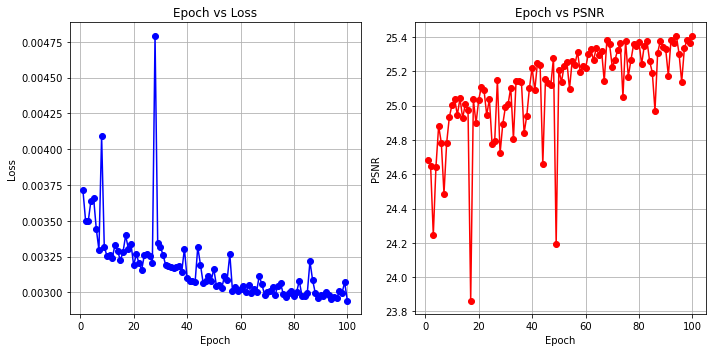

In [41]:
num_epochs=100
# Plot epoch vs loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_values, marker='o', color='b')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot epoch vs PSNR
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), psnr_values, marker='o', color='r')
plt.title('Epoch vs PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.grid(True)

plt.tight_layout()
plt.show()

In [39]:
trained_model_loaded = SRCNN_paper(num_channels=3).to(device)
trained_model_loaded.load_state_dict(torch.load(pthname))


<All keys matched successfully>

/scratch/16368696/ipykernel_649006/1594376166.py:55: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_img = lr_img.resize(hr_img.size, Image.BICUBIC)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


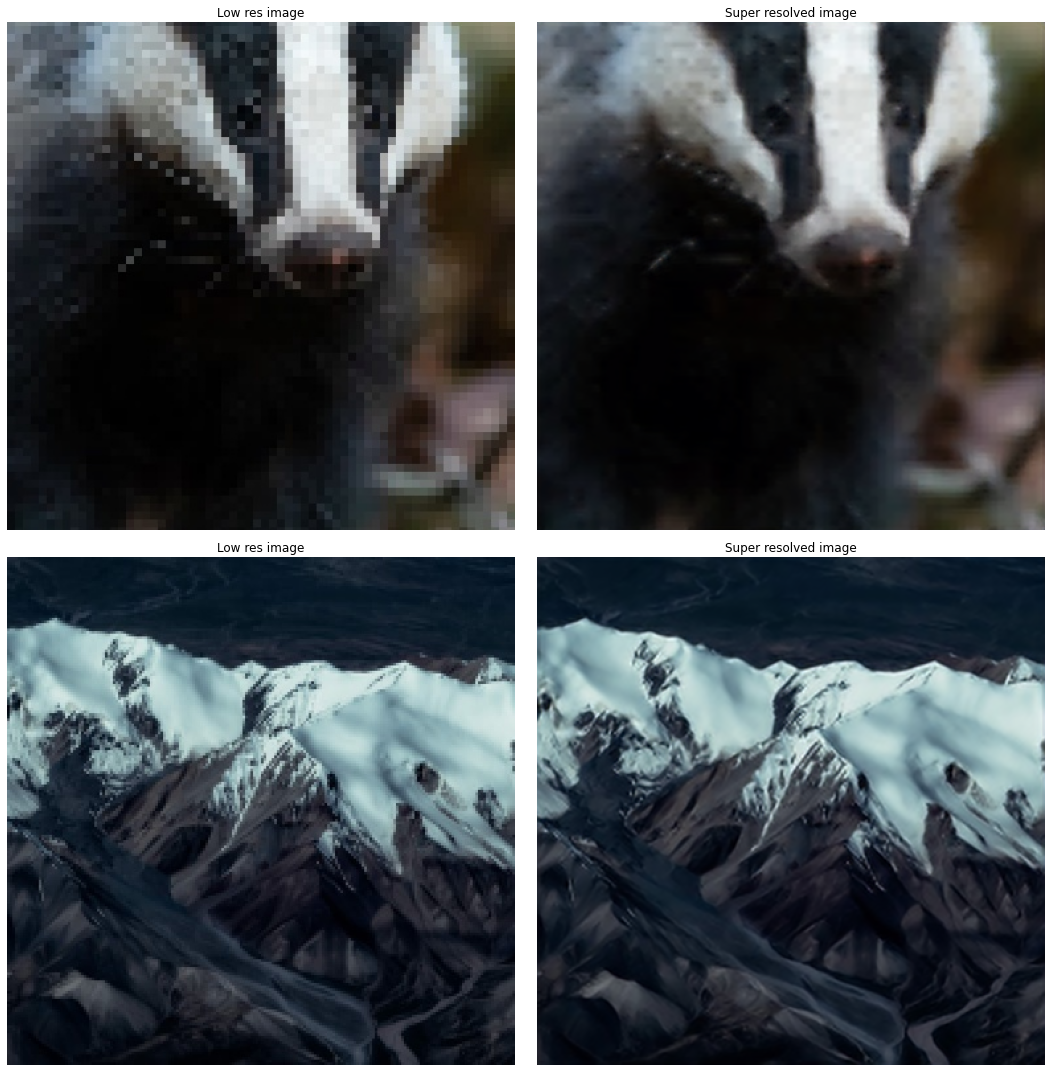

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


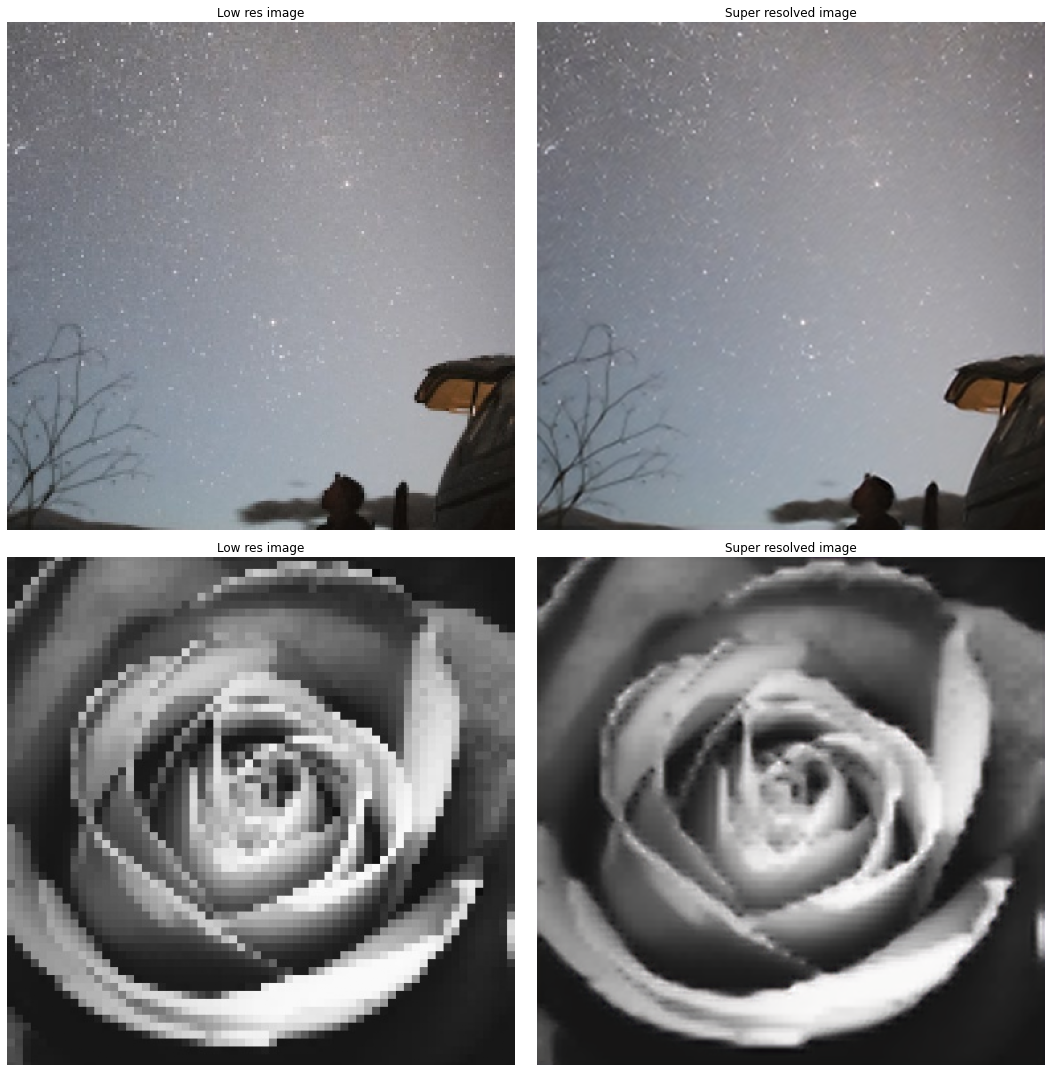

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


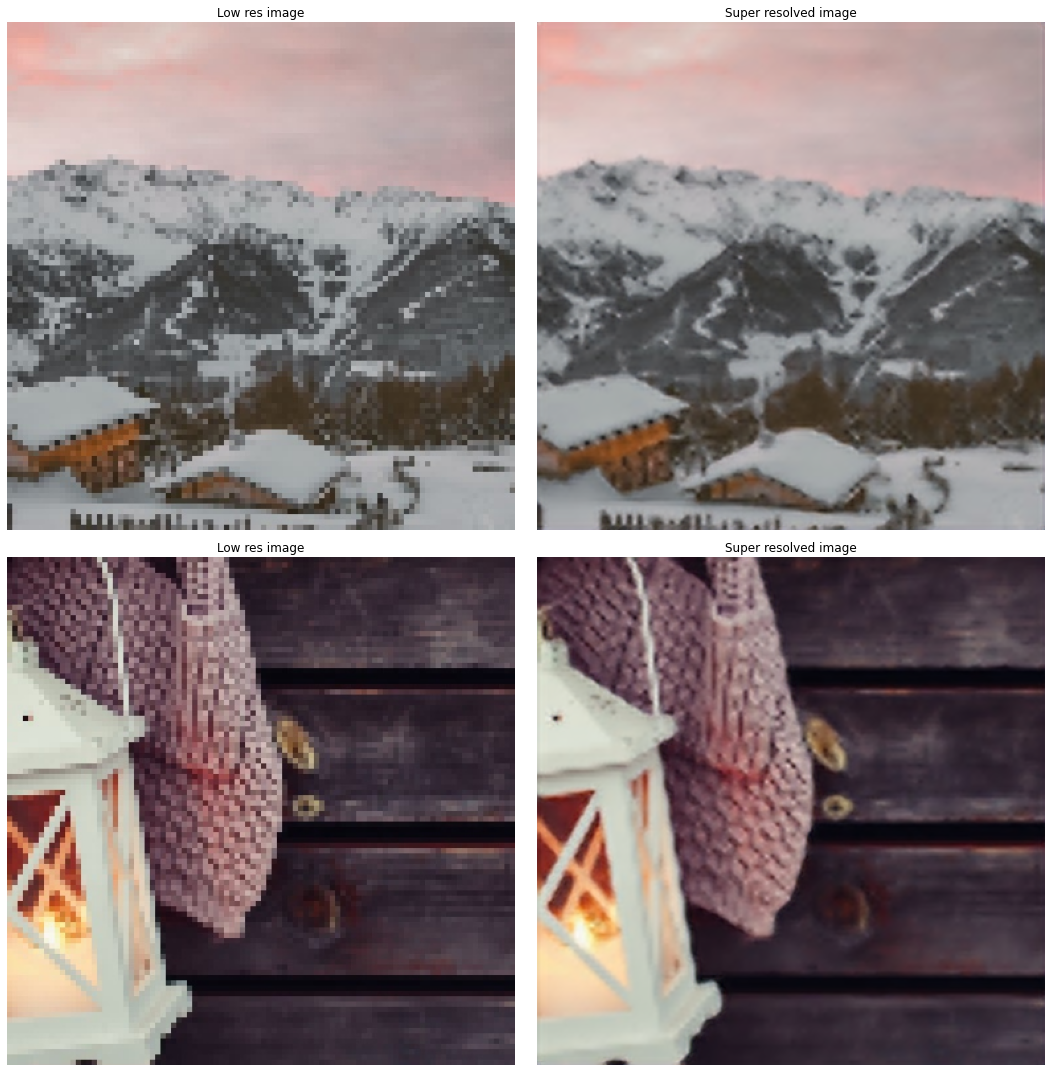

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


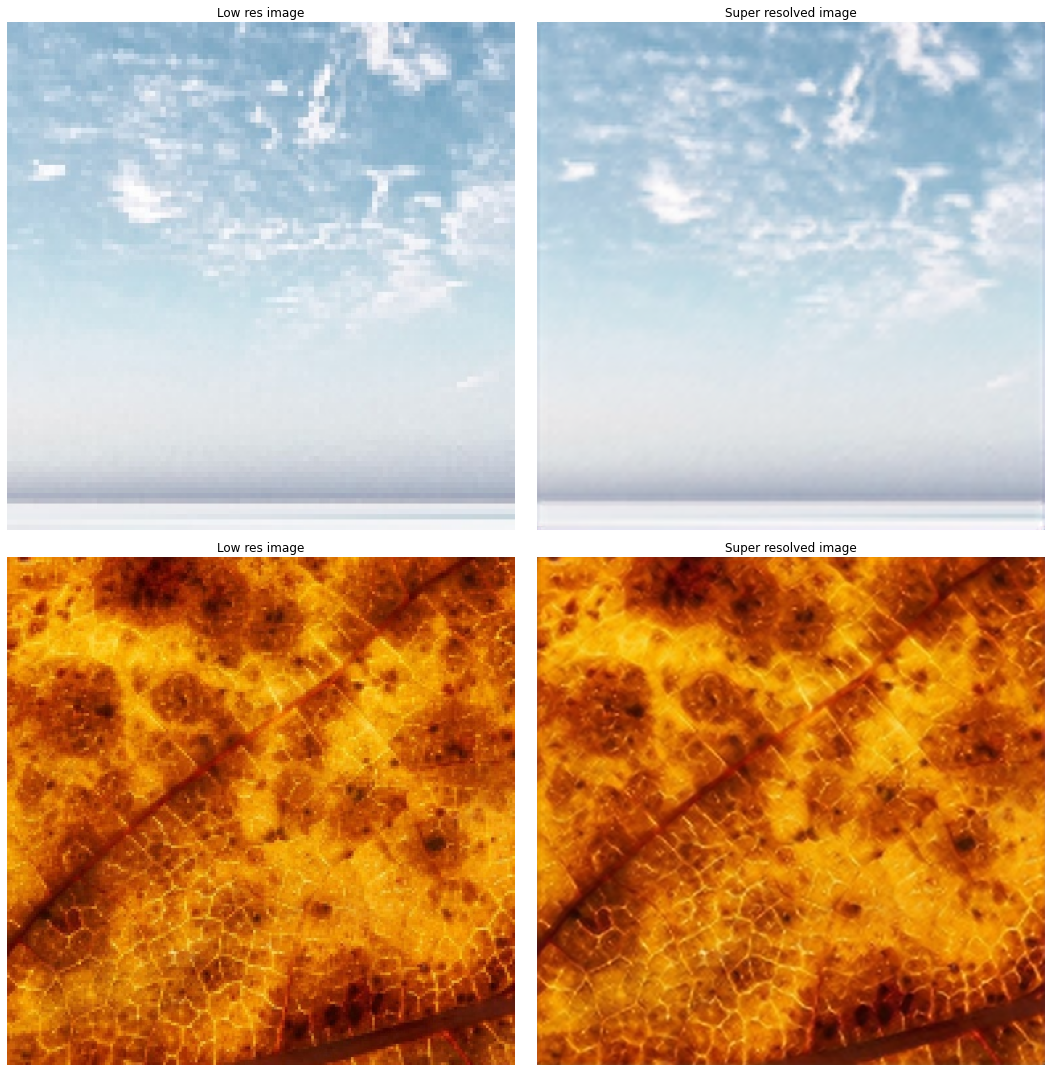

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


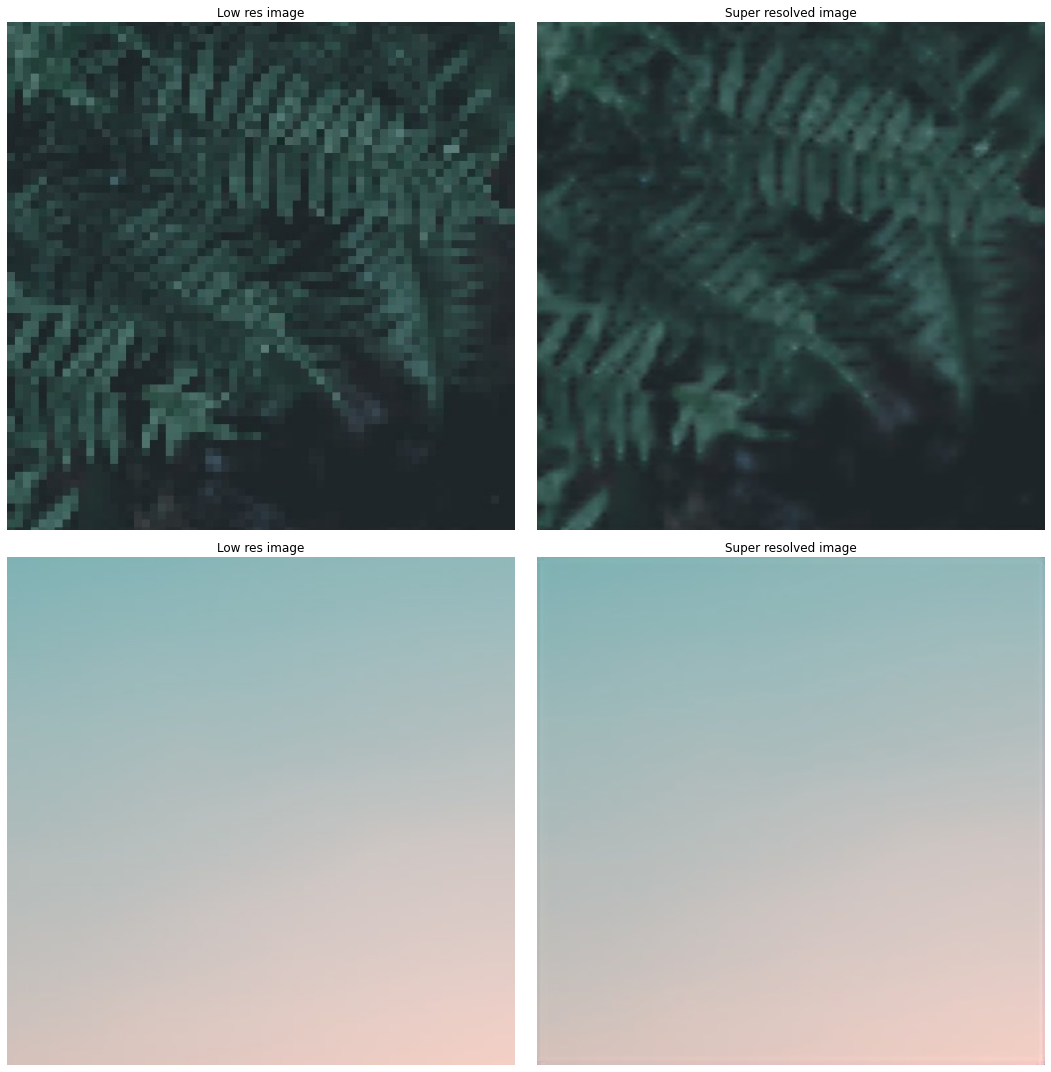

PSNR value for testing dataset is : 25.362759851912486
SSIM value for testing dataset is : 0.7927248163355721


In [40]:
test_model(trained_model_loaded, test_loader)

In [42]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/ImgResProject/SRCNN/e/FSRCNN-5/metadata
